In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import open_clip
import random
import os
from sklearn.metrics.pairwise import cosine_similarity
from huggingface_hub import hf_hub_download
from open_clip import create_model_from_pretrained, get_tokenizer

G:\anaconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
G:\anaconda3\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Load the model and config files from the Hugging Face Hub
model,  preprocess_val = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Model loaded successfully!")

G:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
G:\anaconda3\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Model loaded successfully!


In [3]:
# Function to load image features and caption features
def load_image_and_caption_features(image_folder, caption_file, model, preprocess_val, tokenizer, device, context_length=256):
    # Load the dataset
    caption_df = pd.read_csv(caption_file)
    
    # Create paths for images
    caption_df['Image'] = caption_df['Image'].apply(lambda x: os.path.join(image_folder, x))
    
    # Preprocess images and captions
    images = torch.stack([preprocess_val(Image.open(img)) for img in caption_df['Image']]).to(device)
    captions = tokenizer(caption_df['Caption'].tolist(), context_length=context_length).to(device)

    # Extract features
    with torch.no_grad():
        image_features, caption_features, _ = model(images, captions)
    
    # Move tensors to CPU and convert to numpy arrays
    image_features_np = image_features.cpu().numpy()
    caption_features_np = caption_features.cpu().numpy()

    return caption_df, image_features_np, caption_features_np
    
def display_images_with_captions(df):
    for index, row in df.iterrows():
        img_path = row['Image']  # Get the image path directly from the DataFrame
        img = Image.open(img_path)  # Open the image

        plt.figure(figsize=(5, 5))  # Set the figure size
        plt.imshow(img)  # Display the image
        plt.title(f"Caption: {row['Caption']}", fontsize=12)  # Set the title to the caption
        plt.axis('off')  # Hide the axes
        plt.show()  # Show the image
        
# Function to retrieve top 5 similar samples
def retrieve_top_k_similar(query, query_type, model, preprocess_val, tokenizer, image_folder, caption_file, k=5):
    # Load dataset features
    caption_df, image_features_np, caption_features_np = load_image_and_caption_features(image_folder, caption_file, model, preprocess_val, tokenizer, device)

    # Check if query is an image or caption
    if query_type == 'image':
        # Preprocess the query image
        query_image = preprocess_val(Image.open(query)).unsqueeze(0).to(device)
        
        # Extract features for the query image
        with torch.no_grad():
            query_image_features = model.encode_image(query_image).cpu().numpy()
        
        # Calculate cosine similarity with dataset image features
        similarities = cosine_similarity(query_image_features, image_features_np)[0]

    elif query_type == 'caption':
        # Tokenize the query caption
        query_caption = tokenizer([query], context_length=256).to(device)
        
        # Extract features for the query caption
        with torch.no_grad():
            query_caption_features = model.encode_text(query_caption).cpu().numpy()
        
        # Calculate cosine similarity with dataset caption features
        similarities = cosine_similarity(query_caption_features, caption_features_np)[0]

    else:
        raise ValueError("query_type should be 'image' or 'caption'.")

    # Get top k most similar indices
    top_k_indices = np.argsort(similarities)[-k:][::-1]

    # Return top k most similar samples
    result = caption_df.iloc[top_k_indices], similarities[top_k_indices]
    printable_df, image_scores = result
    print("Top similar "+query_type+": ")
    if query_type == 'image':
        img = Image.open(query)  # Open the image
        plt.figure(figsize=(5, 5))  # Set the figure size
        plt.imshow(img)  # Display the image
        plt.title("Query Image:")
        plt.axis('off')  # Hide the axes
        plt.show()  # Show the image
    else:
        print("Query Caption:")
        print(query)
    
    display_images_with_captions(printable_df)
    return result




In [4]:
# Example usage
image_folder = r'G:\USER\Documents\GitHub\QL4POMR\Datasets\Paper Samples\Samples\Images'
caption_file = r'G:\USER\Documents\GitHub\QL4POMR\Datasets\Paper Samples\Samples\Samples.csv'


G:\anaconda3\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


Top similar image: 


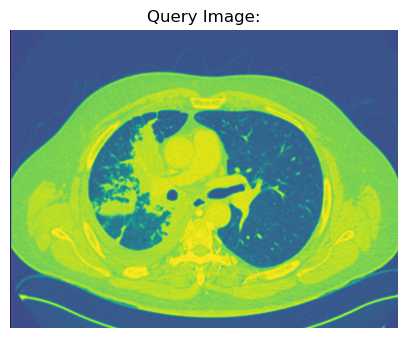

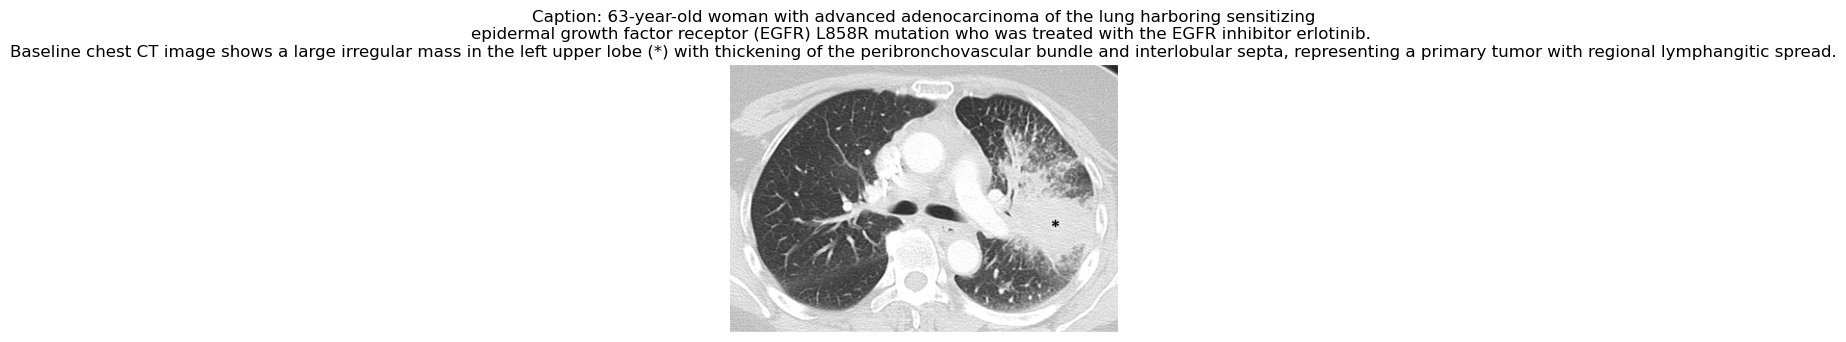

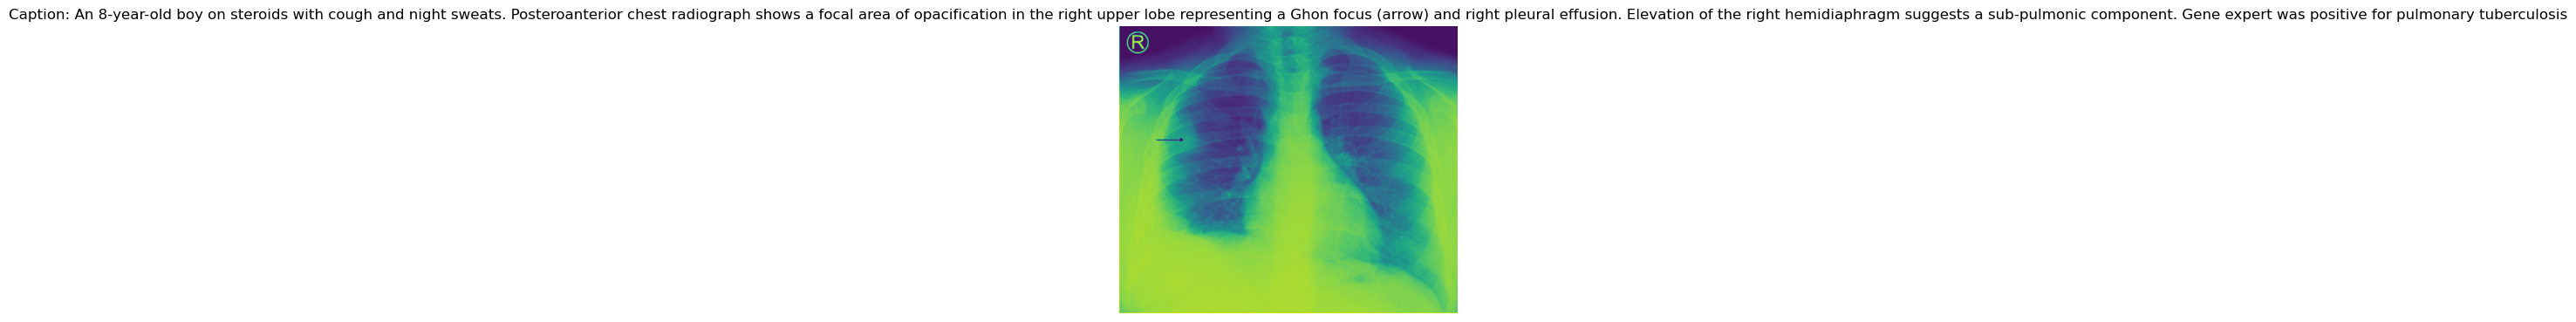

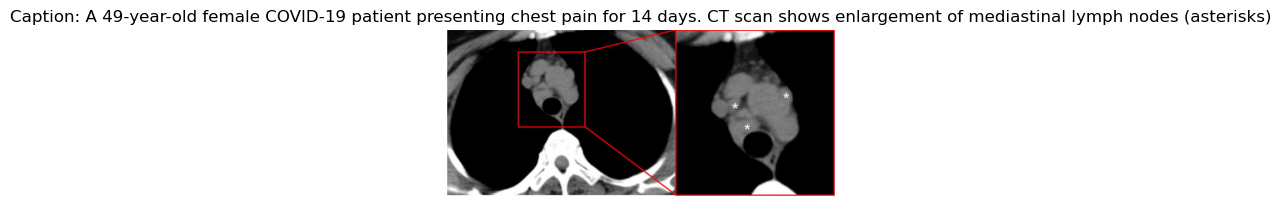

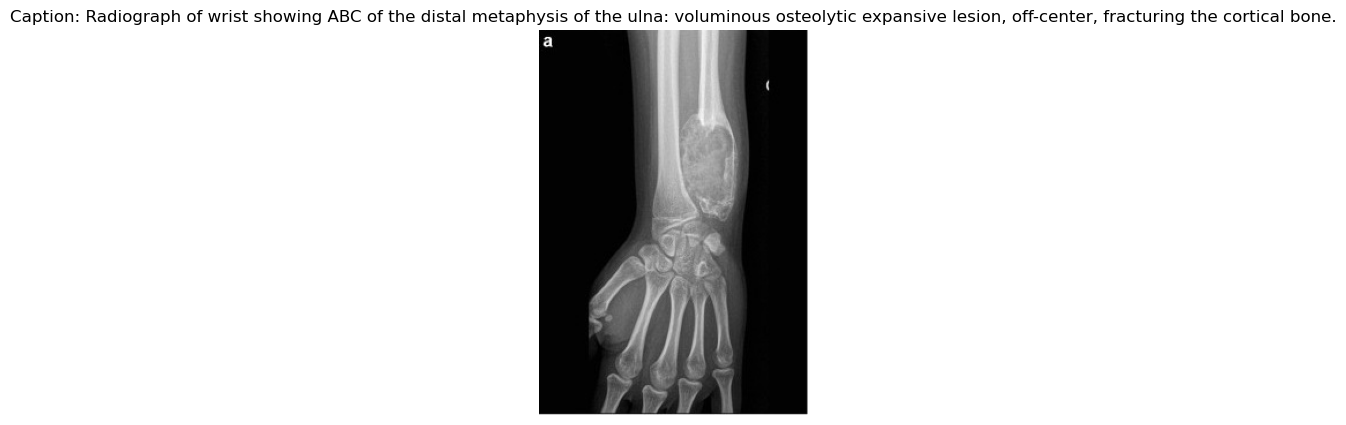

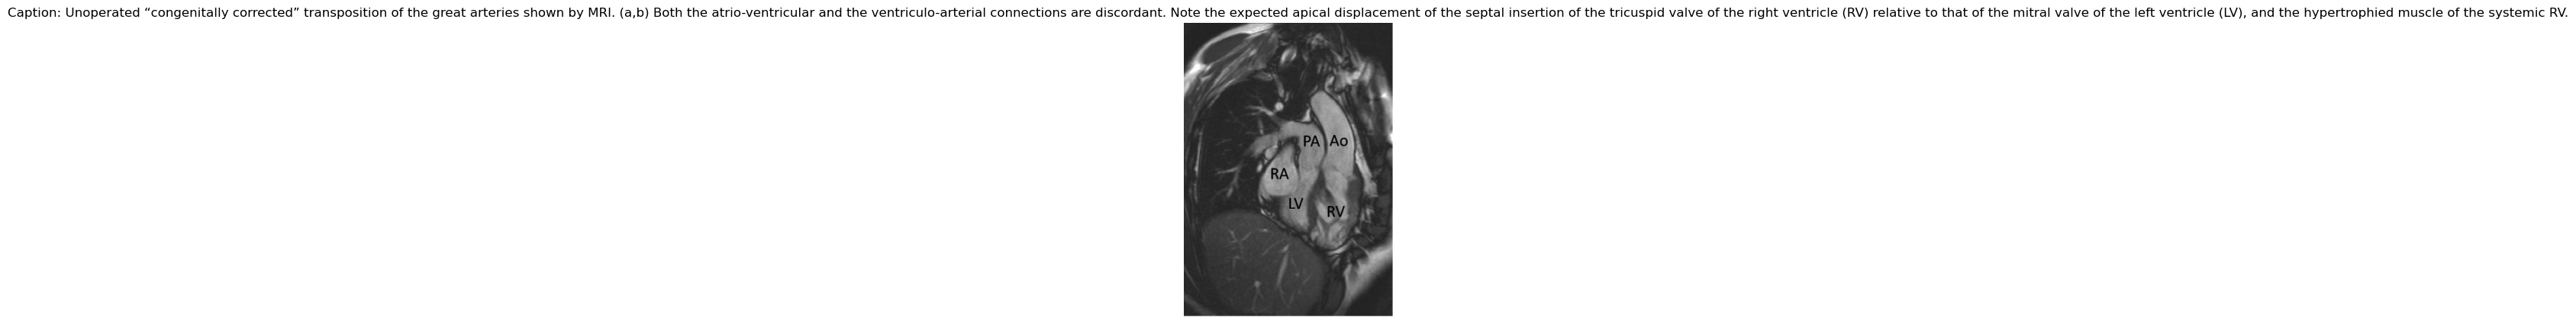

In [5]:
# Use the first image and caption from the dataset as input for the similarity retrieval

# Extract the first image path and first caption from the DataFrame
first_image_path = os.path.join(image_folder, "test sample.png") 
first_caption = "Lung adenocarcinoma presenting as a dense pneumonic consolidation with mediastinal infiltration, lymphadenopathy and lung metastases."

# Perform retrieval for image query
top_similar_images, image_scores = retrieve_top_k_similar(first_image_path, 'image', model, preprocess_val, tokenizer, image_folder, caption_file)

Top similar caption: 
Query Caption:
Lung adenocarcinoma presenting as a dense pneumonic consolidation with mediastinal infiltration, lymphadenopathy and lung metastases.


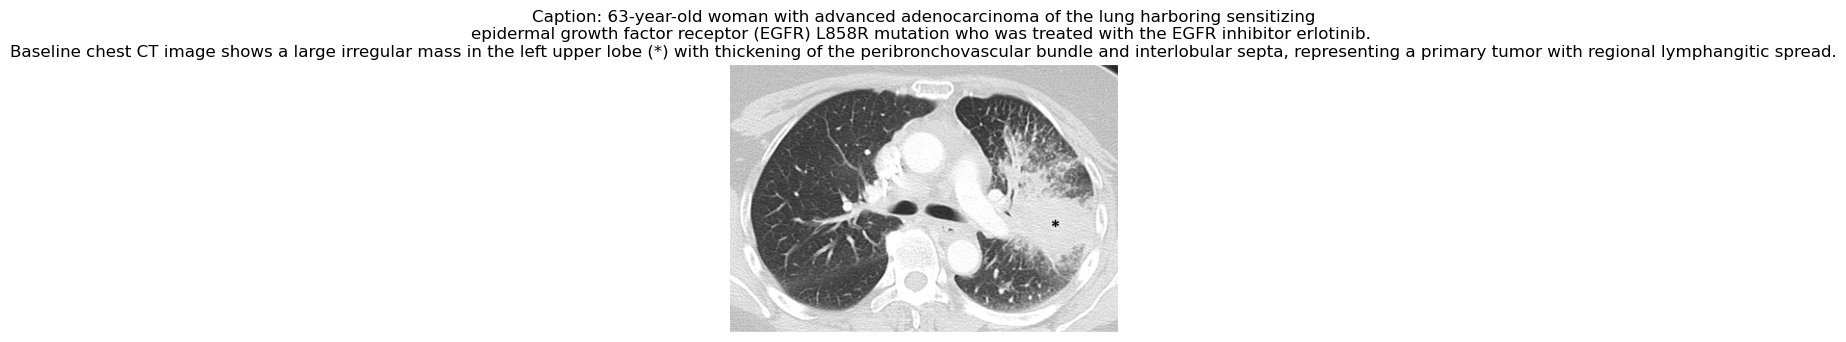

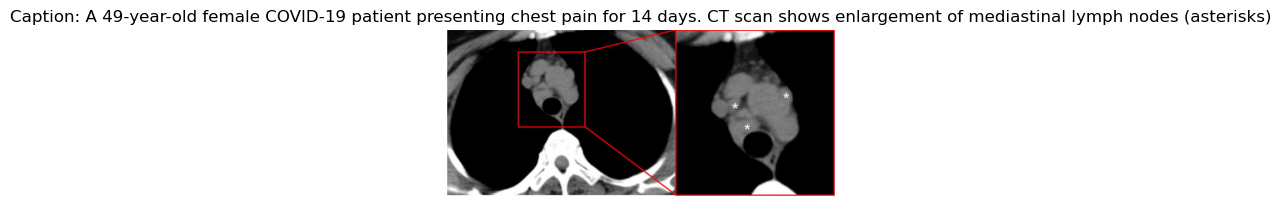

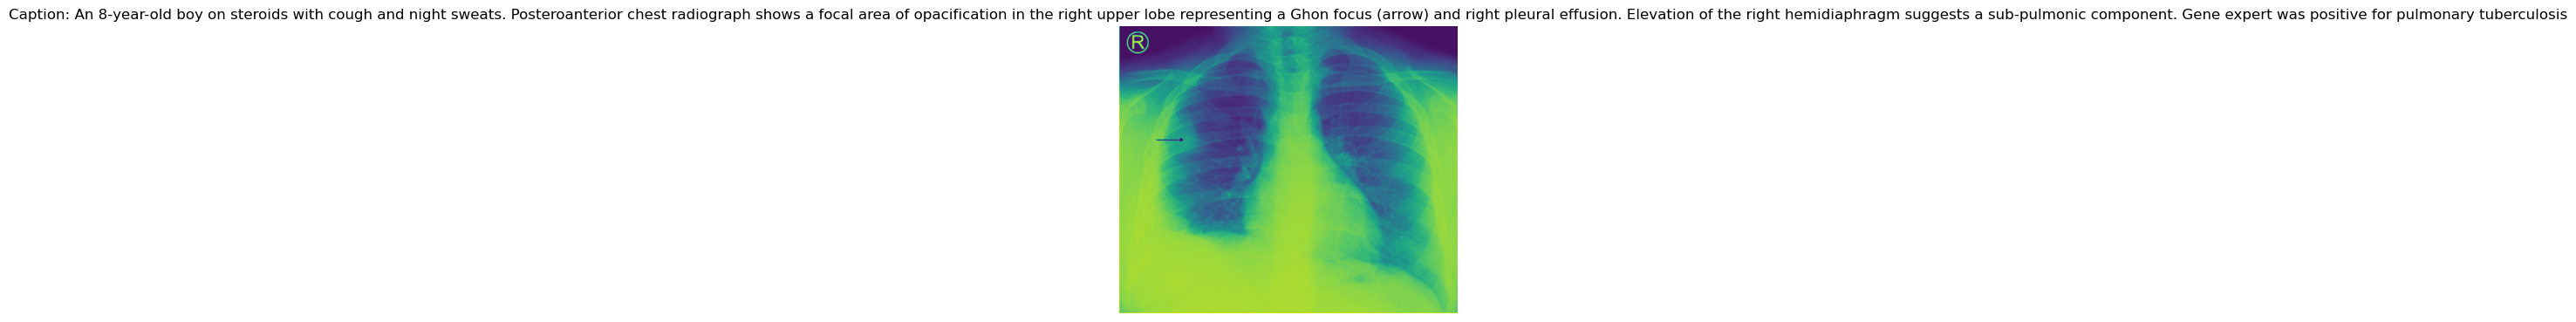

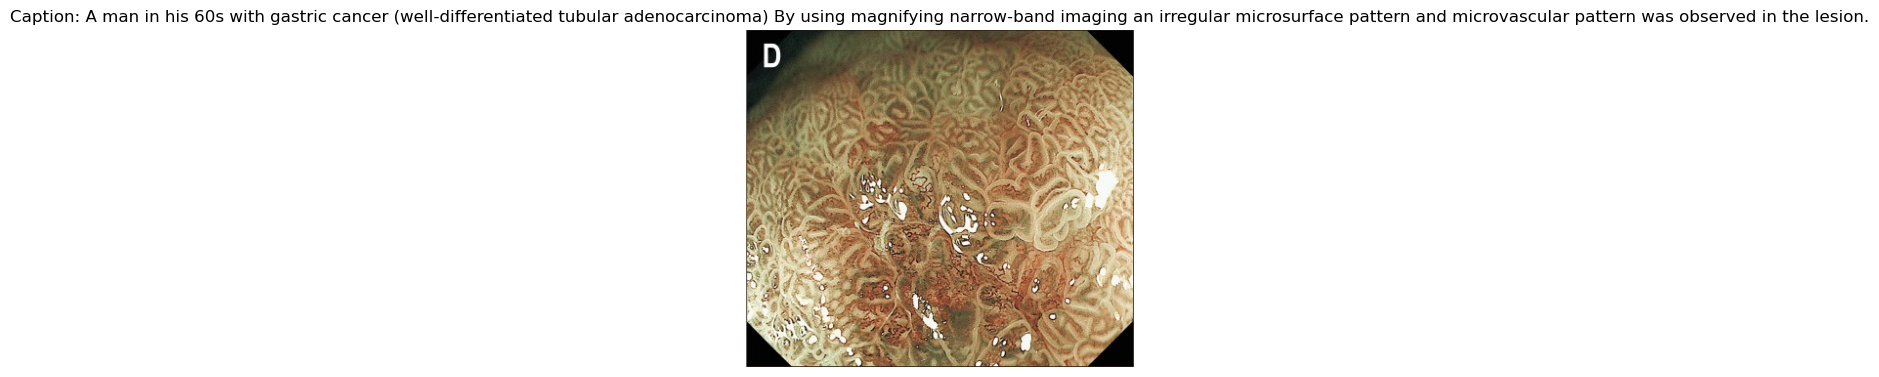

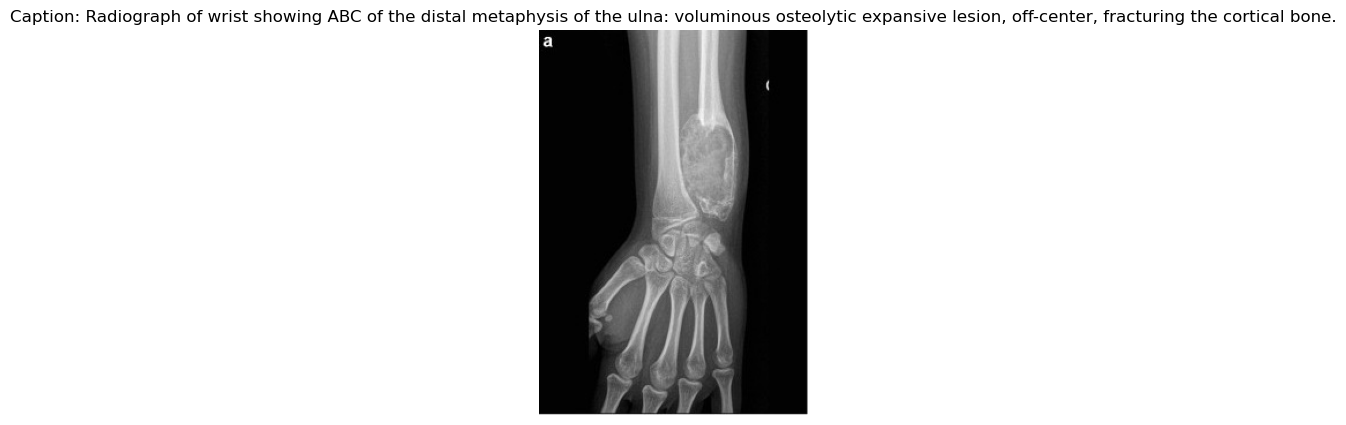

In [6]:
# Perform retrieval for caption query
top_similar_captions, caption_scores = retrieve_top_k_similar(first_caption, 'caption', model, preprocess_val, tokenizer, image_folder, caption_file)